## Potato Disease Classification

Dataset credits: https://www.kaggle.com/arjuntejaswi/plant-village

In [51]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

#### Import all the Dependencies

In [52]:
import random

### Set all the constants

In [53]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50

#### Import data into tensorflow dataset object

We will use image_dataset_from_directory api to load all images in tensorflow dataset:
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [54]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed = 123,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 3251 files belonging to 3 classes.


In [55]:
class_names = dataset.class_names
class_names

['Early_Blight', 'Healthy', 'Late_Blight']

In [56]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 0 0 2 0 2 0 2 0 2 2 0 2 1 0 0 2 1 1 1 0 0 1 2 2 1 0 1 0 2 0 2]


As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels.

### Visualize some of the images from out dataset

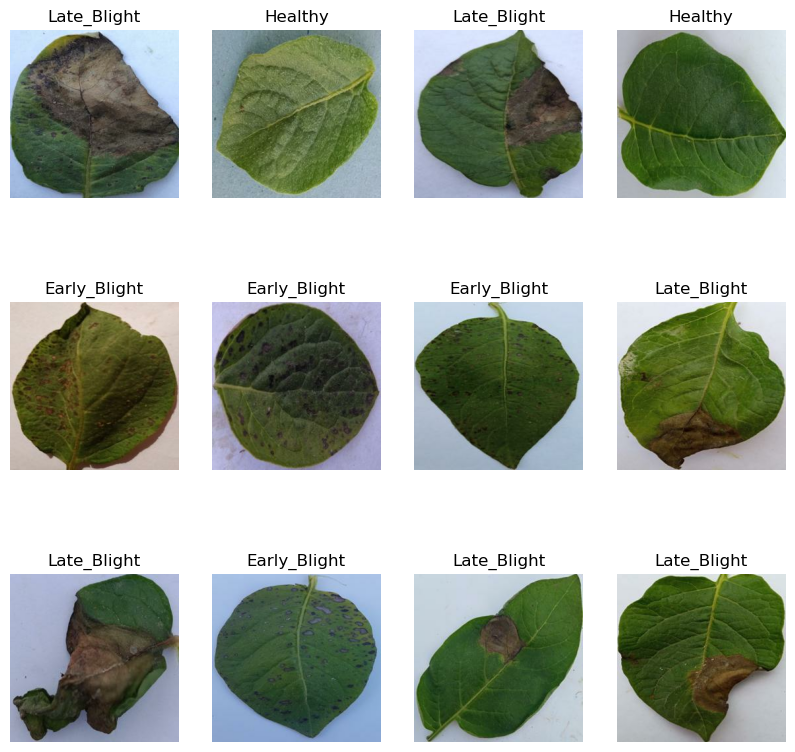

In [57]:
plt.figure(figsize = (10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, mainly:
1. Training - dataset to be used while training.
2. Validation - dataset to be tested against while training.
3. Testing - dataset to be tested against after we trained a model

In [58]:
len(dataset)

102

In [59]:
train_size = 0.8
len(dataset) * train_size

81.60000000000001

In [60]:
train_ds = dataset.take(54)
len(train_ds)

54

In [61]:
test_ds = dataset.skip(54)
len(train_ds)

54

In [62]:
test_ds = dataset.skip(54)
len(test_ds)

48

In [63]:
val_size = 0.1
len(dataset) * val_size

10.200000000000001

In [64]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [65]:
test_ds = test_ds.skip(6)
len(test_ds)

42

In [66]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if (shuffle):
        ds = ds.shuffle(shuffle_size, seed = 12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [67]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [68]:
len(train_ds)

81

In [69]:
len(val_ds)

10

In [70]:
len(test_ds)

11

### Cache, Shuffle and Prefetch the Dataset

In [71]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Building the Model

#### Creating a Layer for Resizing and Normalization

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256, 256) image to gain (256, 256). We really don't need this but it is useful when we are done with the training and start the model for predictions. at that time someone can supply an image that is not (256, 256) and this layer will resize it.

In [72]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255),
])

#### Data Augmentation

Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [73]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

#### Applying Data Augmentation to Train Dataset

In [74]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training = True), y)
).prefetch(buffer_size = tf.data.AUTOTUNE)

Model Architecture

We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [75]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [76]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

### Compiling the Model

We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric 

In [77]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [78]:
history = model.fit(
    train_ds,
    batch_size = BATCH_SIZE,
    validation_data = val_ds,
    verbose = 1,
    epochs = 50,
)

Epoch 1/50


81/81 [==============================] - 43s 499ms/step - loss: 1.0466 - accuracy: 0.4347 - val_loss: 1.0402 - val_accuracy: 0.4187
Epoch 2/50
81/81 [==============================] - 39s 475ms/step - loss: 0.9338 - accuracy: 0.5491 - val_loss: 0.7843 - val_accuracy: 0.7000
Epoch 3/50
81/81 [==============================] - 39s 486ms/step - loss: 0.7110 - accuracy: 0.7305 - val_loss: 0.7818 - val_accuracy: 0.7156
Epoch 4/50
81/81 [==============================] - 39s 478ms/step - loss: 0.5020 - accuracy: 0.8154 - val_loss: 0.4403 - val_accuracy: 0.8344
Epoch 5/50
81/81 [==============================] - 39s 478ms/step - loss: 0.3826 - accuracy: 0.8558 - val_loss: 0.2982 - val_accuracy: 0.8938
Epoch 6/50
81/81 [==============================] - 39s 482ms/step - loss: 0.3001 - accuracy: 0.8879 - val_loss: 0.2735 - val_accuracy: 0.8875
Epoch 7/50
81/81 [==============================] - 39s 475ms/step - loss: 0.2755 - accuracy: 0.9046 - val_loss: 0.2369 - val_accuracy: 0.8969
Epoch 8/50

KeyboardInterrupt: 

In [ ]:
scores = model.evaluate(test_ds)

11/11 [==============================] - 3s 126ms/step - loss: 0.0291 - accuracy: 0.9943


You can see above that we get 100% accuracy for our test dataset. This is considered a pretty good accuracy

In [ ]:
scores

[0.02908489853143692, 0.9943181872367859]

Scores is just a list containing loss and accuracy value

#### Plotting the Accuracy and Loss Curves

In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 81}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Loss, accuracy, val loss etc are a Python list containing values of loss, accuracy etc at the end of each epoch

In [ ]:
type(history.history["loss"])

list

In [ ]:
len(history.history["loss"])

50

In [ ]:
history.history["loss"][:5] # show loss for first 5 epochs

[0.12942636013031006,
 0.0960661992430687,
 0.07628866285085678,
 0.08208994567394257,
 0.09926547855138779]

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

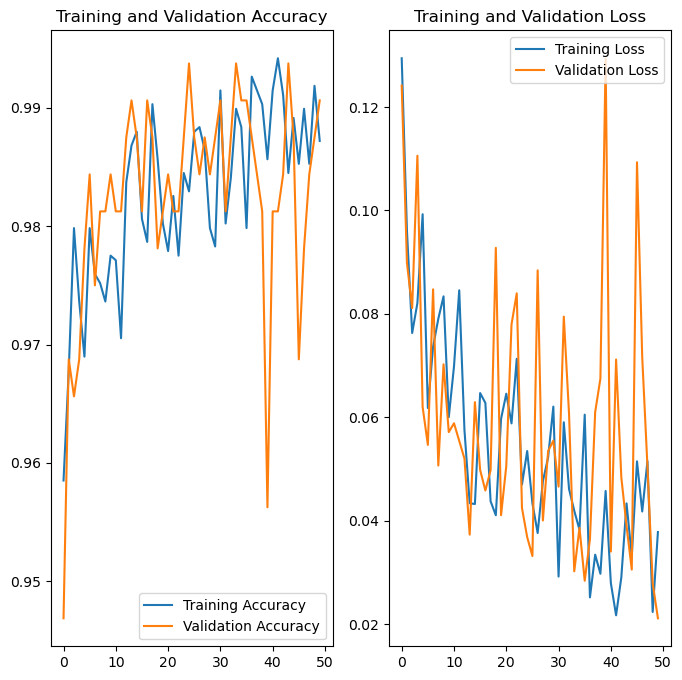

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Run prediction on a sample image

first image to predict
actual label: Late_Blight


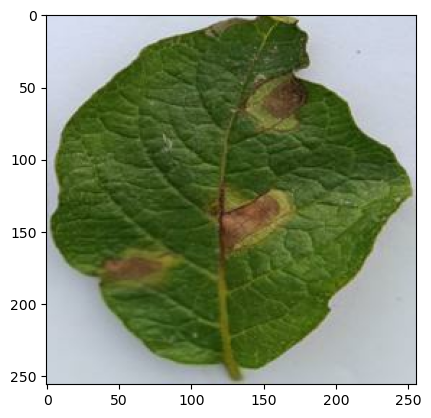

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype("uint8")
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])

    ...

Now run inference on few sample images

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 34ms/step


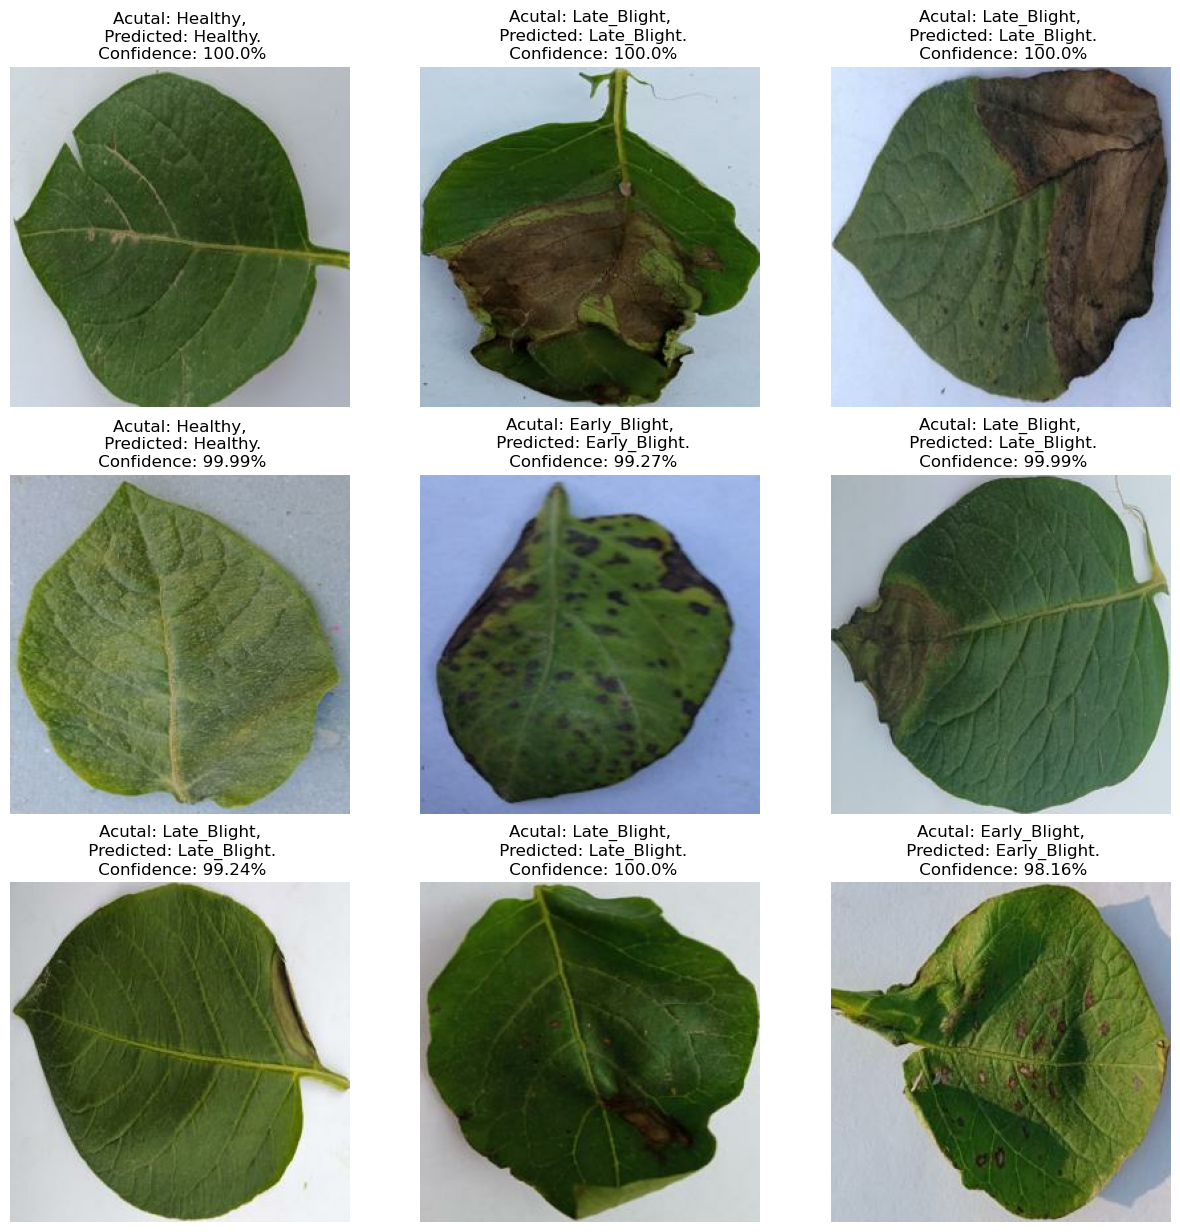

In [ ]:
plt.figure(figsize = (15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Acutal: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

#### Saving the model

We append the model to the list of models as a new version

In [86]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../models'

In [83]:
model.save("../potatoes.h5")

C:\Users\ayunker\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
